# EE123 Lab 2: Software Defined Radio - Part III

### Written by Miki Lustig and Frank Ong

In [1]:

# Import functions and libraries
from __future__ import division
import numpy as np, matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
from rtlsdr import RtlSdr
import threading,time
import gc
import pyModeS as pms

#import bokeh.plotting as bk
#from bokeh.models import ColumnDataSource
#from bokeh.io import push_notebook
#bk.output_notebook()
#from IPython.html.widgets import interact


%matplotlib inline

## Task II: Capturing, detecting and extracting Mode S ADS-B Packets with RTL-SDR

The following text is adapted from (https://github.com/bistromath/gr-air-modes).

__Mode S__ is the transponder protocol used in modern commercial aircraft.
A Mode S-equipped aircraft replies to radar interrogation by either
ground radar (secondary surveillance) or other aircraft ("Traffic
Collision Avoidance System", or TCAS).

__Automatic Dependent Surveillance-Broadcast (ADS-B)__ is a communication
protocol using the Extended Squitter capability of the Mode S transport
layer.  The protocol is:

* Automatic: it requires no pilot input
* Dependent: it is dependent on altimeter, GPS, and other aircraft
  instrumentation for information
* Surveillance: it provides current information about the transmitting
  aircraft
* Broadcast: it is one-way, broadcast to all receivers within range.

ADS-B-equipped aircraft broadcast ("squitter") their position, velocity,
flight number, and other interesting information to any receiver within
range of the aircraft. Position reports are typically generated once per
second and flight indentification every five seconds.

Packets are sent at 1090Mhz and use Pulse Position Modulation (PPM) at a rate of 1Mbit per second. The simple modulation scheme is designed to be trancieved by cheap hardware -- which is very much what we are doing in this lab!

Pulse position modulation belongs to the family of amplitude modulated signals and in particular to the type of amplitude-shift-keying (ASK) or on-off-keying (OOK). In OOK, `0`, `1` bits are sent by turning the carrier on and off. PPM uses [Manchester](http://en.wikipedia.org/wiki/Manchester_code) encoding variant of OOK. The idea in Machester encoding is that in each bit interval there is always a transition between on and off and the transition occurs in the middle of the bit interval. For example, a transition from off to on would represent a `0` and a transition from on to off would represent a `1`. Manchester codes have the advantage of being self clocking so the clock can be recovered from the data stream. 

A mode S ADS-B packet consists of an $8\mu$s preamble followed by a data block of 56 or 112 $\mu$s data block. A preamble is a signal used in network communications to synchronize transmission timing between two or more systems. Here's a diagram that illustrates a typical packet:


<img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/adsb-packet.png" alt="Drawing" style="height: 200px;"/>

Now, since the bit-rate is 1Mbit per second, then a sampling rate of 2Msample/sec should be sufficient to capture the bit transitions, detect the preamble and deode packets. In practice, ADS-B packets can be decoded using the rtl-sdr, but the captured data does not look like the ideal packet. Here's an example of a part of a captured packet:

<img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/real_adsb_packet.png" alt="Drawing" style="height: 200px;"/>

( This packet is rescaled to have a maximum amplitude of 128. Your packet does not neccessarily have this height, in fact, the maximum value of packets you will receive will be between 0.0 and 1.0)


As you can see, there are many distortions: the key-off is not zero and there are variations in the amplitudes of the key-on. These come from various sources including the anti-aliasing filters, interfering signals, noise, gain control and more. However, it is possible to clearly see the preamble and the packet bit content! This is pretty amazing that this can be done using a 12$ usb dongle because ADS-B equipment is very expensive.

There are several types and subtypes of "Squitters":

* Short squitters are 56bits (8bits Control,  24bits address, 24bits parity check)
* Long squitters are 112bits (8bits control, 24bits address, 56bits ADS message, 24bits parity)

Only the long squitters have location information in them. 

### Task: Acquire samples  
When acquiring data, it is highly recommneded that you be OUTSIDE or close to a BIG window. Electromagnetic radiation at 1090MHz does not penetrate through walls. In addition, the antenna you got with the dongle is not ideal for ADS-B reception. It is also recommended that you do this part during the day and not at night, when the air-traffic in the bay area is low. 

_Remember that the absolute gain of the signal is not important. It is the relative gain between your signal and noise that affects the detection, so a higher SDR gain does not mean a better signal-to-noise ratio (SNR)._

* Set the rtl-sdr to a center frequency of 1090MHz, sampling rate of 2MS/s and a gain slightly higher than the middle in the list of possible gains (37-42 are good choices). You can play with the gain later if the results are not satisfactory. 
* Acquire 2,048,000 samples (approx 1 sec) and take their magnitude. We will only work with magnitude data. 
* Plot the magnitude of the received signal. Do you see any strong bursts in the amplitude? If you don't, repeat this task untill you do. This will make sure you have data to work with.
* If you see very small values where "noise" is, that means that your gain is too low. Try increasing the gain.


#### Memory leakage problem with matplotlib
It turns out that there's a memory leakage problem in matplotlib. If you plot repeatedly, some memory will not be cleared. This can be a problem on the raspberryPi, which has limited amount of memory. 

To check the memory status on the pi:
```
! free  -h
```

If you have less than 500Mb, then you will have trouble as we move forward with the lab. 


A work around for clearing most of the memory leak is to run the following code **after** plotting:
```
%xdel -n fig
%xdel -n p
gc.collect(2) # Garbage collection for python
``` 


In [ ]:
%matplotlib inline

# acquire data

sdr = RtlSdr()
fs = 2000000;
sdr.set_sample_rate(fs)    # sampling rate
sdr.set_center_freq(1090e6)   # 1090MhZ center frequency
sdr.set_gain(43.4) 
N_Samples = 2048000 # approx 1 sec
y = abs(sdr.read_samples(N_Samples))   # get samples


width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
p = plot( (y ))
title('magnitude of received signal')
xlabel('samples')

sdr.close()




In [ ]:
! free -h

In [ ]:
%xdel -n fig
%xdel -n p
gc.collect(2)

In [ ]:
! free -h

* Save the magnitude of the data to a file. This will help you in the programming and debugging portions, so you don't have to reacquire date and rely on airplanes to be present all the time. Use the feature `np.save('adsb.npy',y)` to save the array. Use `np.load` to load it back. You can also use the data we provided for you (through the lab link) for debugging, but please submit plots from your OWN data. 

In [ ]:
#np.save('adsb_mine.npy',y)

In [20]:
y = np.load('adsb.npy')
fs = 2000000;

y = abs(y) / max(abs(y))



Before we start at automatically detecting packet, let's look at one. Use the ``%matplotlib notebook`` interactive interface for the plotting to help you scroll through the signal. 

* Manually look for a packet in the received signal. Look for ones with high amplitude. You can use `nonzero(y == max(abs( y)))[0]` to find the index of the maximum signal. 
* Display the packet from `idx` to `idx + 16 + 112 * 2`, where `idx` is the start index of the packet

<IPython.core.display.Javascript object>


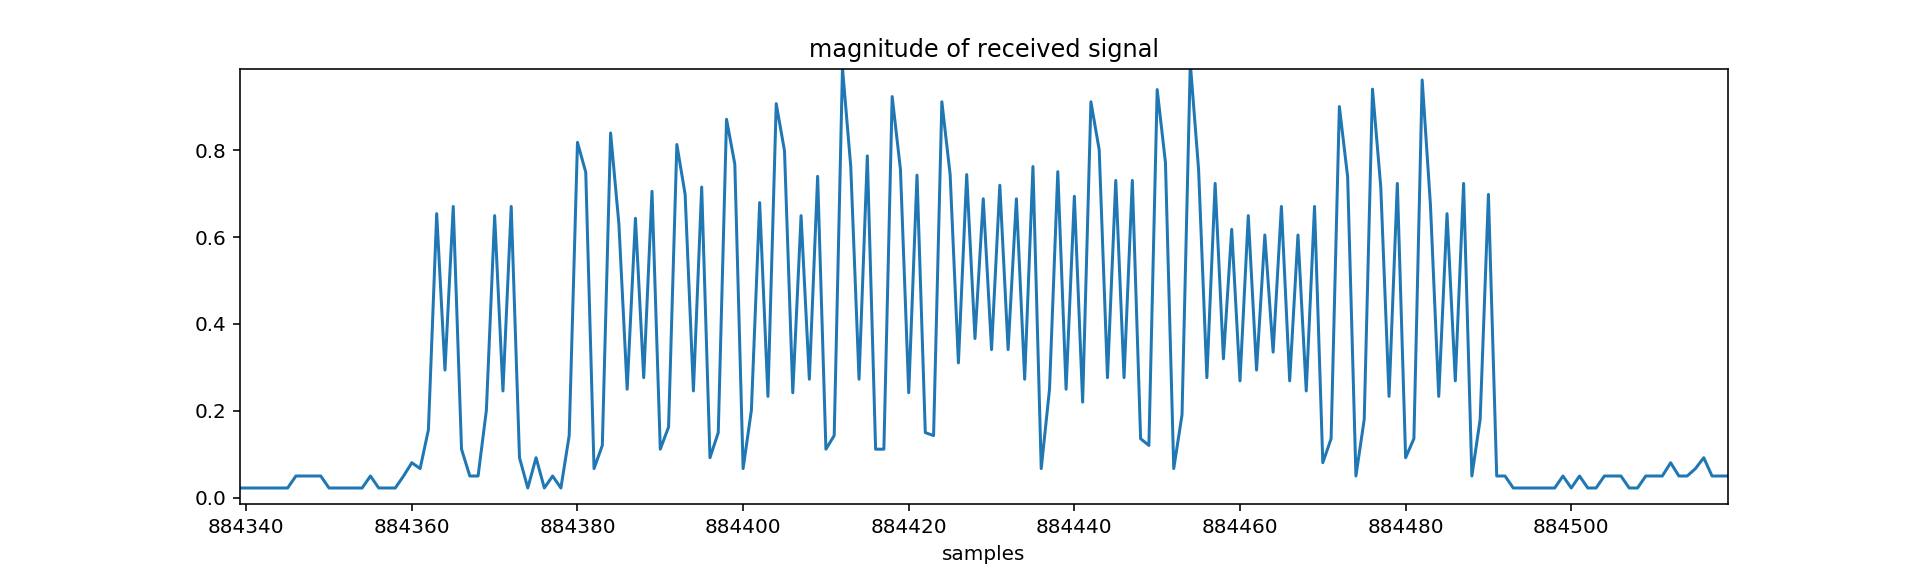

In [21]:
%matplotlib notebook
%matplotlib notebook


width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
p = plot( r_[0:len(y)],abs(y))
title('magnitude of received signal')
xlabel('samples')




<Container object of 3 artists>

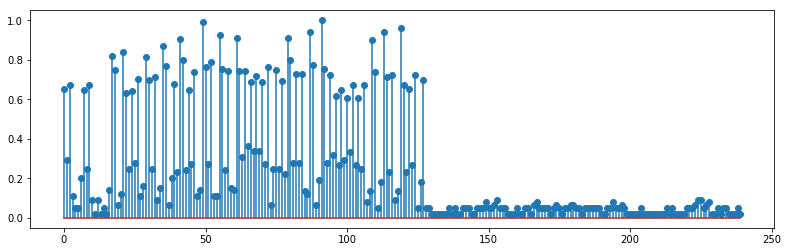

In [33]:
# Display the chunk
%matplotlib inline
#idx = nonzero(y == max(abs(y)))[0]
#print(idx)

idx = 884363
chunk_length = 112 * 2 + 16
#y_chunk = y[idx[0]: idx[0] + chunk_length] 
y_chunk = y[idx: idx + chunk_length] 
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.stem(abs(y_chunk))


Answer the following questions:

* Is this a long or short squitter?
* Manually decode the 1st 8 bits of the packet. Provide the values with your answer.  If the first sample of the chunk is the begining of the preamble, then the following code will decode the manchester-coding and return the bits content of the packet:

```
bits = y_chunk[16::2] > y_chunk[17::2]
```


In [34]:
# Code Here:
bits = y_chunk[16::2] > y_chunk[17::2]

print(bits)

[False  True False  True  True  True False  True  True False  True False
 False  True  True  True False  True  True False  True  True False  True
  True  True  True  True  True False False False  True  True  True False
  True False  True  True  True  True  True  True  True  True False  True
 False  True  True False  True  True  True False False False False False
  True  True False False False False False False False False  True False
  True False  True False False False False  True False False  True  True
 False False False False False  True False  True False False  True False
 False False False False False False False False False False  True False
 False  True False  True]


Answers Here:

It's a short squitter.
___

## Decoding Mode-S packets. 

We will use the pyModeS package to decode and look at some of the information in the packet you received. The [Github](https://github.com/junzis/pyModeS) contain some information. Much more information can be found [Here](http://mode-s.org/decode/).

You will need the following ``bool2Hex`` function to convert your numpy boolean ndarray into the format expected by pyModeS:

In [35]:
def bool2Hex(lst):
    tmp =  ''.join(['1' if x else '0' for x in lst])
    return hex(int(tmp,2))[2:]

To see if the package is valid, with no errors, we can check its CRC. you should get a string of zeros. Otherwise, there's errors. 

For a long squitter you need to provide the function with 28 bytes, for a short squitter 14 bytes. we will try them both. 

```
msg = bool2Hex(bits)
print("Long:", pms.crc(msg))

msg = bool2Hex(bits)
print("Short:",pms.crc(msg[:14))
```

For the purpose of debugging (only if your message does not work),  here's a valid adsb packet:
```
msg = '8da1286c584f34d474cdc937cdbc'
```

In [49]:
msg = bool2Hex(bits)
#msg = '8da1286c584f34d474cdc937cdbc'
print('CRC Long:',pms.crc(msg))
print('CRC Short:',pms.crc(msg[:14]))

CRC Long: 100011100011101110111111
CRC Short: 000000000000000000000000


Next, we will look at the type of packet. The following information is copied from the pyModeS github:
```
Python library for Mode-S message decoding. Support Downlink Formats (DF) are:

Automatic Dependent Surveillance - Broadcast (ADS-B) (DF17)
aircraft information that contains: ICAO address, position, altitude, velocity (ground speed), callsign, etc.
Mode-S Elementary Surveillance (ELS) (DF4 and DF5).
DF4: Altitude
DF5: Squawk code
Mode-S Enhanced Surveillance (EHS) (DF20 and DF21). Additional information in response to SSR interrogation, such as: true airspeed, indicated airspeed, mach number, wind, temperature, etc.
DF20: Altitude
DF21: Squawk code
BDS 2,0 Aircraft identification
BDS 2,1 Aircraft and airline registration markings
BDS 4,0 Selected vertical intention
BDS 4,4 Meteorological routine air report
BDS 5,0 Track and turn report
BDS 5,3 Air-referenced state vector
BDS 6,0 Heading and speed report
```

To find the type of packet, use:

```pms.df(bool2Hex(bits)))```

In [50]:
#Code Here:
pms.df(bool2Hex(bits))


11

Each Mode-S device has a unique number given by the International Civil Aviation Organization (ICAO). This will enable you to identify the airplane. 

If your packet is ADS-B (DF17) run:
```
pms.adsb.icao(bool2Hex(bits))
```

If your packet is ELS (DF4, DF5) run:
```
pms.els.icao(bool2Hex(bits))
```

If your packet is EHS (DF20, DF21) run:
```
pms.ehs.icao(bool2Hex(bits))
```

You can then use the [World Aircraft Database](https://junzis.com/adb/) to quarry the ICAO address.

For example, 

```

|ICAO Addr.	|Reg. ID	|Model	|Aircraft Type	           |Operator	     |Timestamp	         |  
|A34358	    |N30913     |B788	|Boeing 787-8 Dreamliner + |United Airlines +|2018-02-11 18:30:03|

```

In [51]:
#Code Here:
pms.adsb.icao(bool2Hex(bits))


'a76df8'

If the message is of type DF17, i.e. ADS-B, you look further. First check the typecode:
```
pms.adsb.typecode(msg)
```


In [52]:
#Code Here:
pms.adsb.typecode(msg[:14])

29

Typecodes 1-4 will have callsign information, which can extracted via:
```
pms.adsb.callsign(msg)
```

Typecodes 5-8 / 9-18 will have surface/airborne position and altitude information. For position, you will need two packets. Information can be found: [Here](http://mode-s.org/decode/adsb/airborne-position.html), but altitude in ft can be extracted via:
```
pms.adsb.altitude(msg)
```

Typcode 19 will have velocity and heading information:
```
pms.adsb.velocity(msg)          # handles both surface & airborne messages
pms.adsb.speed_heading(msg)     # handles both surface & airborne messages
pms.adsb.surface_velocity(msg)
pms.adsb.airborne_velocity(msg)
```

The example message is typecode 11, so the altitude of the airplane is:

```
print('Altitude:', pms.adsb.altitude(msg),'(ft)')

Altitude: 14675 (ft)
```

In [55]:
#Code Here:
#pms.adsb.callsign(msg)

#pms.adsb.altitude(msg)

#pms.adsb.velocity(msg)          # handles both surface & airborne messages
#pms.adsb.speed_heading(msg)     # handles both surface & airborne messages
#pms.adsb.surface_velocity(msg)
#pms.adsb.airborne_velocity(msg)

## Preamble Detection

We would like to automatically detect packets. Detecting the preamble is a good way to start, as the preamble is the same for all packets. In general, a good detector should have the minimum number of false negatives and false positives. For ADS-B packets, we care more about false negatives, since this means that we may be missing an important packet. At the same time, a false positive would result in a packet which we can not decode, which is not harmful, except that we spend time in extra computation to perform parity checks. 

#### Noise floor estimation
When looking at detection, it is useful to know what is the noise level compared to the signal level. This can help setting thresholds for detecting signals. When noise has Gaussian statistics, we can calculate the sample mean and sample standard deviation to estimate its distribution. Unfortunately, our received signal is not only contaminated by Gaussian random noise (actually, the magnitue is [Rayleigh distributed](https://en.wikipedia.org/wiki/Rayleigh_distribution)  -- not Gaussian, but we will ignore that). It is also contaminated by interference as well as bursts of ADS-B packet data. If we compute the sample mean and standard deviation, they could be biased by strong outliers coming from the packet bursts. 

One solution is to use robust estimation using median calculations. The median is a measure, which is robust to outliers and can be used to estimate the mean. In order to robustly estimate the standard deviation we can use the Median Absolute Deviation (MAD) estimator: http://en.wikipedia.org/wiki/Median_absolute_deviation. The MAD is computed in the following way:

$$ \mathrm{MAD}(X) = \mathrm{median}(|X - \mathrm{median}(X)|) $$

As it turns out, the standard deviation can be approximated from the MAD by:

$$\sigma \approx 1.4826 \mathrm{MAD} $$

While this should work most of the time, I found that the MAD does not work well on the SDR data. The reason is that the SDR has only 8-bit accuracy. This quantization throws off the MAD, and was making me mad as well.

##### Iterative estimation with outlier rejection
Instead, we will look at an iterative calculation which ignores outliers. The idea is simple: We will compute the mean and standard deviation with the outliers. These, will be biased of course. We will use these biased estimators to calculate a threshold and recompute the mean and standard deviation within the threshold -- thus throwing away the largest outliers. We will repeat a few more times till the result converges.

* Compute the mean ``y_mean`` and standard deviation ``y_std`` of the sequence. You will find the functions ``mean`` and ``std`` most useful.
* Compute a threshold -- we will set the threshold to be mean + 4 x standard deviation. This will guarentee that any sample larger than that is likely to be an outlier. 
* Find the indeces of the sequence which are lower than the threshold and repeat the calculations only using these inddeces. You will find the function ``nonzero`` useful.
* Repeat 4 more times -- you will see that the numbers converge quickly -- if not immediately.


In [ ]:
#Code here









#### Signal Amplitude Detector 
Optimal thresholds based on noise are beyond the scope of this lab. However, we need to come up with a threshold for which we can say that a received signal (ANY signal, not just ADS-B) is above it. 
A safe bet would be the mean plus some multiples of the standard deviation. A factor of 3 to 10 is reasonable.  


* set the threshold to be `thresh = y_mean + alhpa*y_std`, when alpha is 3 to 6. (Experiment! It will depend on the lefel of spiky noise in the data as well.)
* find all the indexes for which the received signal is greater than the threshold. Call the list `idx_sig`. We will use these indexes later to detect preambles (Hint: use `nonzero(input)[0]`)

Once you estimated the threshold, you can reuse it for subsequenct captures, and do not need to recalculate it. You can refresh the estimates periodically as things may change over time. 

Plot the sequence again, with a line at the threshold to visualize if you got it correctly. 

In [ ]:
sig_thresh = y_mean+ alpha*y_std
idx_sig = nonzero(y > sig_thresh)[0]

In [ ]:
%matplotlib notebook

width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
p = plot(r_[0:len(y)],abs(y),r_[0:len(y)],ones((len(y)))*sig_thresh)



In [ ]:
plt.close(fig)
%xdel fig
%xdel p
gc.collect(2)

At this point, we suggest that you take a look at the memory status of your system and use the workaround to fre some of the memory matplotlib has taken!


In [ ]:
!free -h

#### Normalized Cross Correlation Detection
Detecting that a signal is received does not mean that it is the right signal! We would like to make sure it is the preamble. There are many ways we can go about detecting the preamble. We already saw in Lab 1 that matched filtering can be used for detection.  Take a look at the ideal preamble below, and  a preamble we (Frank and I) measured when preparing the lab.


<img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/real_adsb_packet.png" alt="Drawing" style="height: 200px;"/>




We saw that matched filtering is implemented using cross correlation. Here, we will also use cross correlation. However, we need to remember to subtract the mean from each of the signals! (We didn't do it for the chirp, since the chirp has zero mean). The cross correlation is defined as:
$$ R_{xy}[n] = \sum_{k=0}^{15} (x[n+k]- \hat{x}_n) (y[k] - \hat{y} )$$
, where $\hat{x}_n$ is the mean of $x$ in a window size 16 around the index $n$.

The issue is that the result would depend on the signal's magnitude. It will be hard to give a "score" for detected or not detected. Therefore we will use a normalized cross correlation instead, which is defined as 
$$ \hat R_{xy}[n] = \frac{\sum_{k=0}^{15} (x[n+k]- \hat{x}_n) (y[k] - \hat{y} )}{||x[n]-\hat{x}_n||\cdot ||y-\hat y||}$$
This will guarentee that the result is bounded between -1 and 1. 

To make the implementation fast and easy, we will first write a function that calculates the normalized cross correlation of a 16 sample window of the signal. We will then, loop through only the indexes of the signal for which the signal amplitude detection was above the threshold.  Using for loops is not an efficient implementation in Python, but it will do for this purpose. You are more than welcome to write your own efficient implementation. 

* Write a function `detectPreambleXcorr(chunck,corrthresh)`. The function accepets an array of 16 samples, e.g., $x[n]\cdots x[n+15]$. It evaluates the normalized cross correlation with an ideal preamble, and returns a True if it is greater than `corrthresh`

In [ ]:
def detectPreambleXcorr(chunck,corrthresh):
    # The function accepets an array of 16 samples, e.g., x[n]⋯x[n+15]. 
    # It evaluates the normalized cross correlation with an ideal preamble, 
    # and returns a True if it is greater than corrthresh
    

    # Your Code here:
    
    
    
    
    
    
    

* Loop over the inputs for which the signal amplitude was above the amplitude threshold to detect packets. Set a correlation threshold of 0.5 . Store all the positions of detected packet in an array `idx_corr`. If you did not detect any packets, reduce the threshold. (Warning: This operation may take more than a minute on some laptops for a low signal threshold, make sure the threshold is set such that you don't have more than 4000 indeces to check)




In [ ]:
if len(idx_sig) < 4000:
    print('You set your threshold well. Good to go!')
else:
    print('Probably should set a higher threshold')

In [ ]:
# Your code here:









* Create a matrix `msgs`, in which each row contains a detected packet. Make each row `(16 + 112*2)` long to accomodate the long squitters. 
* Display the matrix as an image. You should be able to see four vertical lines on the left corresponding to the preamble. Do you see short and long squitters?

In [ ]:
%matplotlib notebook 

# Code here:









width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.imshow(sqrt(msgs), aspect='auto', cmap="gray")
plt.ylabel("Incoming messages")
plt.xlabel("The Received message")

Take a look at this code. It checks the packets CRC, and coundt the valid packets. It also performs some decoding. Run the following to check how many valid messages you captured:


In [ ]:
count=0
for n in r_[0:msgs.shape[0]] :
    bits = msgs[n,16::2] > msgs[n,17::2]
    msg = bool2Hex(bits)
    crc = pms.crc(msg)
    crc_bool = (np.fromstring(crc,dtype=int8)-48) # convert to ASCII and sutract 48 which is ASCII of 0
    if (all (crc_bool==0)):  #Long
        count=count+1
        print(count,")CRC OK, DF",pms.df(msg),"ICAO:",pms.adsb.icao(msg),"typecode:",pms.adsb.typecode(msg),"MSG:",msg)
    else :   #short or nothing
        crc = pms.crc(msg[:14])  # look at a short message
        crc_bool = (np.fromstring(crc,dtype=int8)-48) # convert to ASCII and sutract 48 which is ASCII of 0
        if (all (crc_bool==0)):  # short message
            count=count+1
            print(count,")CRC OK, DF",pms.df(msg),"MSG:",msg[:14])
            

#### Non-linear Classification: Preamble Detection Using Logic

The previous approach is considered a linear classifier. We looked at the correlation and then decided on detection if the correlation was more than 1/2. The issue is, that with noise and interference, the "shape" of the preamble might differe considerably and will result in low-correlation.  There are other classifiers, which can be made immune to different sources of imperfections. 
Our received preambles have varying total amplitudes (planes are near and far), have bias, and also exhibit amplitude modulation. At the same time, the preamble is relatively short. Instead of matched filtering, we can devise a non-linear descriptor which may be more robust. Here, we will look at detecting the preamble using logic.


<img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/real_adsb_packet.png" alt="Drawing" style="height: 200px;"/>


Considering again the ideal preamble.  Notice, that there are four values which are high `[0, 2, 7, 9]`and there are 12 values which are low `[1,3,4,5,6,8,10,11,12,13,14,15]`. If we just consider logic, e.g., comparing high's and low's , we can make our detection significantly more robust to the bias and amplitude modulation.  Another benefit of using logic is that it can be computationally more efficient than normalized matched filtering. Because of this, it is more suitable for real-time applications.

Of course, it is possible to introduce more conditions. For example, in order to avoid detection of noise signal that resembles the logic, we can set a minimum limit on the amplitude of high's we consider a detection. In addition, to be able to separate between high's and low's we need to have a good amplitude margin -- so we can set a threshold for a minimum average margin between them.


* Implement a function `idx_preamble = detectPreamble( y )`. The function will accept the entire signal and will return a list of indices containing the start of each preamble. The basic logic of the function should be based on comparing high's and low's bits. (Hint: use `nonzero` to find the indices that satisfy the conditions). If you want to add thresholds using the mean-variance estimate as well, you are more than welcome! 
* Try to make your function as efficient as possible, since it will be used in real-time in the next part
* Run the function on the signal `y`

For a reference, our own implementation takes less than 3 seconds to finish. 

In [ ]:
def detectPreamble(y):
    # Function accepts sdr samples and returns a list of indices containing the start of each preamble.
    
    
    # Your fast code here:
    
    
    
    
    
    
    


In [ ]:
idx_preamble = detectPreamble( y )

* Create a matrix, in which each row contains a detected packet. Make each row `16 + 112*2` long to accomodate the long squitters. 
* Display the matrix as an image. You should be able to see four vertical lines on the left corresponding to the preamble. Do you see short and long squitters?

In [ ]:
# Your code here:




msgs = 
    

In [ ]:
# Display as an image

width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.imshow(sqrt(msgs), aspect='auto', cmap="gray")
plt.ylabel("Incoming messages")
plt.xlabel("The Received message")

Take a look at this code. It checks the packets CRC, and coundt the valid packets. It also performs some decoding. Run the following to check how many valid messages you captured. Did you decode the same, more or less packets than for the linear classifier?


In [ ]:
count=0
for n in r_[0:msgs.shape[0]] :
    bits = msgs[n,16::2] > msgs[n,17::2]
    msg = bool2Hex(bits)
    crc = pms.crc(msg)
    crc_bool = (np.fromstring(crc,dtype=int8)-48) # convert to ASCII and sutract 48 which is ASCII of 0
    if (all (crc_bool==0)):  #Long
        count=count+1
        print(count,")CRC OK, DF",pms.df(msg),"ICAO:",pms.adsb.icao(msg),"typecode:",pms.adsb.typecode(msg),"MSG:",msg)
    else :   #short or nothing
        crc = pms.crc(msg[:14])  # look at a short message
        crc_bool = (np.fromstring(crc,dtype=int8)-48) # convert to ASCII and sutract 48 which is ASCII of 0
        if (all (crc_bool==0)):  # short message
            count=count+1
            print(count,")CRC OK, DF",pms.df(msg),"MSG:",msg[:14])

Answer Here:


_____

### Some more details:

Now that you can detect the preambles, the only task left is to decode the messages. 
In general, you have enough information to build an application that receives data from the SDR, detects packets, decodes, looks for position information and display that in real-time with google maps API. 
But in the next part of the lab, we have provided an ADS-B decoder so that you can extract flight positions and uses your functions. 

Before this, here's a simple example:

In a second test data called ``adsb2.npy``, which can be found on the website there are enough packets to decode positioning. This data was captured on 02/11/2018 around 7pm. There were 5 long squitters that can be detected and decoded. In particular, there are two of typecode 11, which contain the position information. You should have been able to decode these, and I encourage you to. 

To decode position, you need an even and an odd typecode 11 packet. Even and odd packets are determined by the 54th bit in the packet (or index 53). 

the first typecode 11 messages received was:
```
msg1 = '8d406b4a584d34c354ca7db928f7'
```
the second 
typecode 11 messages received was:
```
msg2 = '8d406b4a584d412ed01ce01be074'
```

Looking at the 54th bit:

``print(pms.util.hex2bin(msg1)[53])``
``print(pms.util.hex2bin(msg1)[53])``

we see that the ``msg1`` is odd, and ``msg2`` is even. 

To get the position we need to tell the decoding function which was first. We will set a timestamp of 0 
for the first message (odd) and a timestamp 1 for the second message (even). The numbers are not important. What is important is which one was first.

```
pos = pms.adsb.position(msg2,msg1,1,0)
```

which results in (37.77429, -122.12122)

typing 37.77429, -122.12122 into a google map search will show the position!


The altitude can be decoded by:
```
alt1 = pms.adsb.altitude(msg1)
alt2 = pms.adsb.altitude(msg2)
```

These will give 14275' and 14300', which means the airplane was ascending!

One of the other packets was a typecode 19, which has airborn velocity and heading information.
```
msg3 = '8d406b4a9909750d00888abb0521'
velocity = pms.adsb.velocity(msg3)
heading = pms.adsb.speed_heading(msg3)
```

We get heading=(385, 74.5) which means 385 knots (443 MPH) and 74.5 degrees -- which means the aircraft was heading north-east.

We get velocity = (385,74.5,2112,'GS') corresponding to (speed in knots, heading in degress, rate of climb in ft/min, and speed type 'GS'/'AS' for ground/air speed)

Finally, we look at the ICAO address in any of the packets:
```
icao = pms.adsb.icao(msg3)
```
which gives icao= 406b4a. This is a boing 787-9 Dreamliner operated by Virgin Atlantic which was going from SFO to LHR.


In [ ]:
msg1 = '8d406b4a584d34c354ca7db928f7'
msg2 = '8d406b4a584d412ed01ce01be074'
msg3 = '8d406b4a9909750d00888abb0521'

In [ ]:
# code to decode packet informations and position here:






## You are now ready to proceed to the real-time flight radar lab